# Project : Medical Treatment

This project will focus on solving the problem of interpreting genetic mutations being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track, because we need your help to take personalized medicine to its full potential.

In [16]:
# Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [17]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('C:/DS_Project/msk-redefining-cancer-treatment/training_variants')

In [18]:
# Exploratory Analysis of the Data set
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


Understanding the above data. There are 4 fields above:

• ID : row id used to link the mutation to the clinical evidence

• Gene : the gene where this genetic mutation is located

• Variation : the aminoacid change for this mutations

• Class : class value 1-9, this genetic mutation has been classified on

In [19]:
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("C:/DS_Project/msk-redefining-cancer-treatment/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [20]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [21]:
# Performing Descriptive Analysis
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [22]:
# Checking dimension of data
data_variants.shape

(3321, 4)

In [23]:
# Checking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [24]:
# Now Peforming exploratory analysis on the training Text data set
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [25]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [26]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [27]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [28]:
data_text.shape

(3321, 2)

Now we will work to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column.

In [29]:
# Viewing the unique values of the Class variable
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Since we have multiple discrete outputs, this is considered a Multi-class classification problem. Therefore we want the ML model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. This means we like to have result for each class in terms of Probablity.

We will evaluate our model using Confusion matrix and Multi class log-loss. Because there is a significant amount of text data. We need to pre process it. So lets write a function for preprocessing the text data.

In [30]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
stop_words = set(stopwords.words('english'))

In [31]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [32]:
# Continued data preprocessing
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

Now merge both the datasets remembering that ID was common column.

In [33]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [34]:
# Check for missing values so that no problems occur during final analysis
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


Since we have 5 rows with missing values. There are two ways we can remove the missing data. We can:

• Drop the rows with missing values or,

• Impute the rows with missing values

In [37]:
# Remove rows with missing values
result = result.drop([1109,1277,1407,1639,2755], axis=0)

In [38]:
# Verify rows with missing values are gone
result.shape

(3316, 5)

# Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [39]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Now we start our split process in train, test and validation data set.

In [44]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [45]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


Verifying the distribution of data in train, test and validation set.

In [59]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [64]:
test_class_distribution

1    113
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64

**Visualizing for train class distribution**

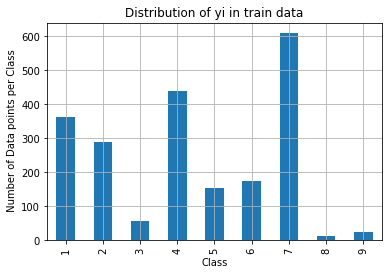

In [66]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's view distribution in form of percentages

In [62]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.713 %)
Number of data points in class 4 : 439 ( 20.698 %)
Number of data points in class 1 : 362 ( 17.067 %)
Number of data points in class 2 : 289 ( 13.626 %)
Number of data points in class 6 : 174 ( 8.204 %)
Number of data points in class 5 : 155 ( 7.308 %)
Number of data points in class 3 : 57 ( 2.687 %)
Number of data points in class 9 : 24 ( 1.132 %)
Number of data points in class 8 : 12 ( 0.566 %)


**Visualizing the same for Test data set**

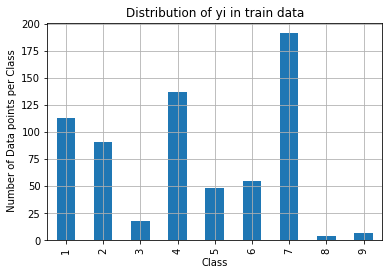

In [63]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [67]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.765 %)
Number of data points in class 4 : 137 ( 20.633 %)
Number of data points in class 1 : 113 ( 17.018 %)
Number of data points in class 2 : 91 ( 13.705 %)
Number of data points in class 6 : 55 ( 8.283 %)
Number of data points in class 5 : 48 ( 7.229 %)
Number of data points in class 3 : 18 ( 2.711 %)
Number of data points in class 9 : 7 ( 1.054 %)
Number of data points in class 8 : 4 ( 0.602 %)


**Visualizing the same for Cross validation data set**

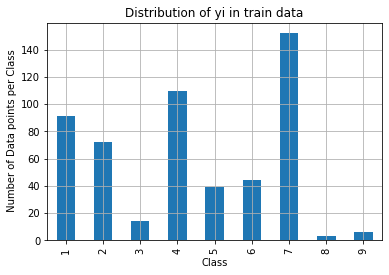

In [68]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [69]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 152 ( 28.625 %)
Number of data points in class 4 : 110 ( 20.716 %)
Number of data points in class 1 : 91 ( 17.137 %)
Number of data points in class 2 : 72 ( 13.559 %)
Number of data points in class 6 : 44 ( 8.286 %)
Number of data points in class 5 : 39 ( 7.345 %)
Number of data points in class 3 : 14 ( 2.637 %)
Number of data points in class 9 : 6 ( 1.13 %)
Number of data points in class 8 : 3 ( 0.565 %)


Evaluating Log Loss between the predicted probability and the observed target.

## Building a Random model

We will generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [70]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [71]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.454444726647956


In [72]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.4439552061876073


In [73]:
# Now we will get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [74]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([7, 5, 1, 0, 1, 6, 7, 1, 1, 3, 5, 3, 5, 7, 2, 3, 3, 1, 8, 1, 7, 7,
       4, 0, 5, 2, 6, 6, 3, 3, 1, 8, 1, 0, 2, 1, 1, 2, 5, 5, 6, 2, 7, 7,
       3, 6, 6, 8, 1, 1, 2, 5, 5, 4, 6, 4, 0, 7, 1, 6, 5, 8, 5, 5, 4, 2,
       0, 5, 5, 1, 7, 5, 8, 2, 5, 5, 3, 1, 7, 1, 6, 6, 4, 8, 7, 3, 7, 5,
       3, 1, 5, 2, 6, 3, 3, 8, 8, 3, 2, 2, 0, 0, 1, 0, 7, 1, 1, 7, 5, 6,
       0, 1, 2, 3, 4, 5, 3, 7, 2, 3, 3, 0, 7, 4, 0, 4, 3, 6, 5, 7, 3, 4,
       6, 3, 5, 7, 4, 1, 3, 0, 6, 3, 4, 2, 3, 0, 7, 2, 8, 4, 1, 5, 7, 1,
       5, 6, 5, 7, 4, 3, 1, 6, 7, 2, 7, 2, 2, 7, 7, 4, 7, 2, 0, 3, 1, 0,
       1, 0, 0, 7, 5, 1, 3, 8, 3, 2, 2, 3, 5, 7, 4, 4, 0, 1, 1, 2, 5, 7,
       1, 2, 2, 3, 1, 2, 0, 8, 1, 3, 1, 5, 4, 6, 6, 5, 0, 4, 8, 8, 2, 1,
       6, 5, 6, 2, 6, 3, 6, 7, 3, 2, 2, 6, 1, 5, 4, 7, 2, 1, 3, 6, 7, 6,
       7, 8, 7, 8, 8, 7, 0, 1, 0, 5, 7, 1, 8, 5, 1, 0, 4, 5, 7, 3, 3, 1,
       2, 2, 3, 4, 4, 3, 6, 3, 4, 0, 0, 1, 6, 7, 8, 7, 6, 7, 0, 2, 1, 6,
       0, 0, 7, 5, 0, 8, 7, 3, 1, 8, 0, 6, 4, 0, 8,

In [75]:
# You can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.
predicted_y = predicted_y + 1

### Confusion Matrix

In [76]:
C = confusion_matrix(y_test, predicted_y)

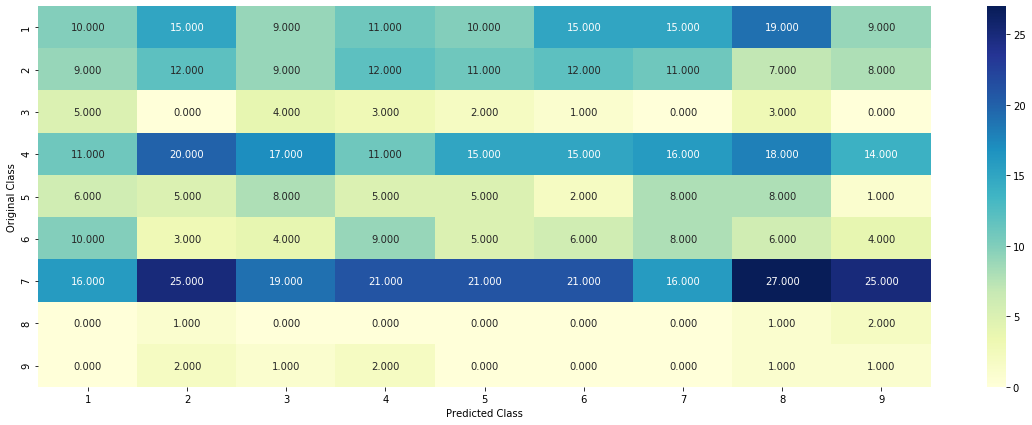

In [77]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [78]:
B =(C/C.sum(axis=0))

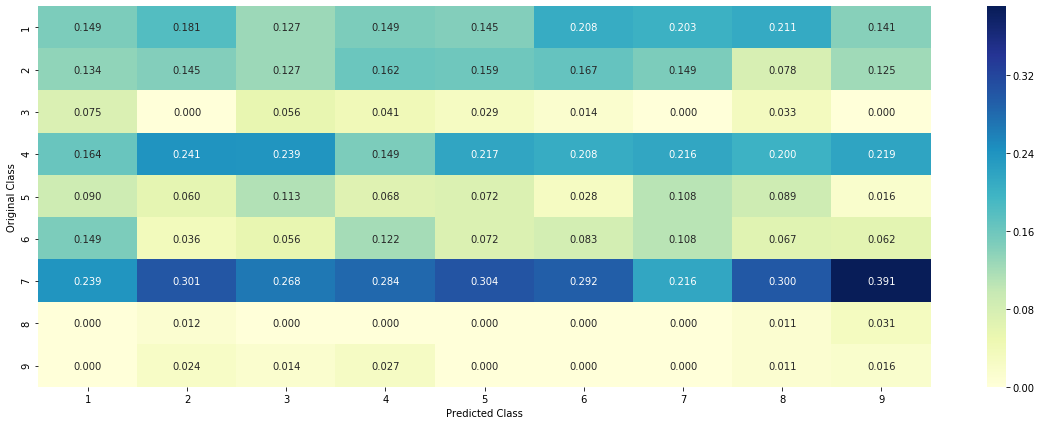

In [79]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Recall matrix

In [80]:
A =(((C.T)/(C.sum(axis=1))).T)

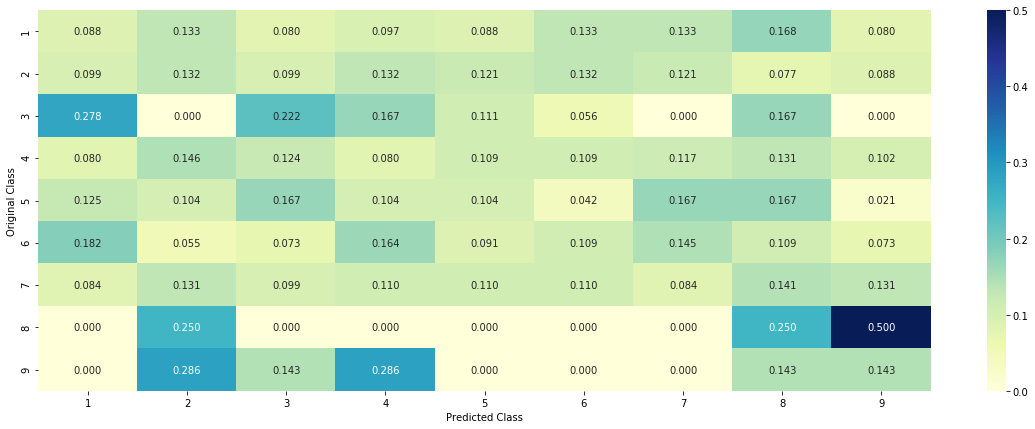

In [81]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Now performing univariate analysis. Evaluating Gene Column

Now we will look at each independent column to make sure its relavent for target variable.

In [82]:
# Looking at the uniqueness of the Gene variable distribution
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 233
BRCA1     178
TP53       95
EGFR       88
BRCA2      84
PTEN       82
KIT        68
BRAF       66
ERBB2      43
ALK        43
PDGFRA     39
Name: Gene, dtype: int64


In [83]:
unique_genes.shape[0]

233

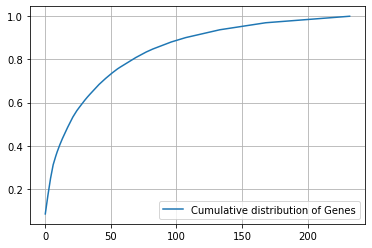

In [84]:
# Viewing the comulative distribution of unique Genes values
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Now we need to convert these categorical variables to appropirate format for the machine learning algorithm to be able to take as an input.

So we have 2 techniques to deal with it.

<ol><li>
     ***One-hot encoding*** </li>
    <li> ***Response Encoding*** (Mean imputation) </li>
</ol>

Let's use both of them to see which one work the best.

In [85]:
# lets start encoding using one hot encoder of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [86]:
# check the number of column generated after one hot encoding
train_gene_feature_onehotCoding.shape

(2121, 232)

In [87]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',


Now we create Response encoding columns for Gene column

In [88]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea